## Data Analysis

In [23]:
# importing libraries
import numpy as np # For numerical computation
import pandas as pd # Data manipulation
import seaborn as sns # plotting
import scipy.io # reading matlab files in python
from scipy import signal #signal processing
from scipy.fftpack import fft, dct #signal processing

from sklearn.linear_model import LinearRegression #linear regression model
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import KFold, train_test_split # cross validation split
from sklearn.metrics import mean_squared_error
import warnings
warnings.filterwarnings('ignore')

from matplotlib import pyplot as plt # For plotting graphs(Visualization)

import os # system-wide functions
os.listdir('/kaggle/input/BloodPressureDataset')

['part_4.mat',
 'part_9.mat',
 'part_10.mat',
 'Samples',
 'part_11.mat',
 'part_3.mat',
 'part_1.mat',
 'part_8.mat',
 'part_5.mat',
 'part_6.mat',
 'part_7.mat',
 'part_2.mat',
 'part_12.mat']

In [24]:
# defining our evaluation error function
def rmse(y_true, y_pred):
    return np.sqrt(mean_squared_error(y_true, y_pred))

In [25]:
sample_file = scipy.io.loadmat(f'../input/BloodPressureDataset/part_{1}.mat')
print(f'sample_file Data type: {type(sample_file)}')
print(f'sample_file keys:\n{sample_file.keys()}')

sample_file Data type: <class 'dict'>
sample_file keys:
dict_keys(['__header__', '__version__', '__globals__', 'p'])


In [26]:
# Loading a sample .mat file to understand the data dimensions
test_sample = scipy.io.loadmat(f'../input/BloodPressureDataset/part_{1}.mat')['p']
print(f'test_sample Data type: {type(test_sample)}')
print(f'test_sample shape/dimensions: {test_sample.shape}')

test_sample Data type: <class 'numpy.ndarray'>
test_sample shape/dimensions: (1, 1000)


In [27]:
print(f"Total Samples: {len(test_sample[0])}")
print(f"Number of readings in each sample(column): {len(test_sample[0][0])}")
print(f"Number of samples in each reading(ECG): {len(test_sample[0][0][2])}")

temp_mat = test_sample[0, 999]
temp_length = temp_mat.shape[1]
sample_size = 125

print(temp_length)
print((int)(temp_length/sample_size))

Total Samples: 1000
Number of readings in each sample(column): 3
Number of samples in each reading(ECG): 61000
9000
72


In [28]:
sample_size = 125
ppg = []
for i in range(1000):
    temp_mat = test_sample[0, i]
    temp_length = temp_mat.shape[1]
    for j in range((int)(temp_length/sample_size)):
        temp_ppg = temp_mat[0, j*sample_size:(j+1)*sample_size]
        ppg.append(temp_ppg)

In [29]:
ecg = []
bp = []
sbp = [] #Systolic Blood Pressure
dbp = [] #Diastolic Blood Pressue
size = 125 #sample size

for i in range(1000):
    temp_mat = test_sample[0, i]
    temp_length = temp_mat.shape[1]
    for j in range((int)(temp_length/sample_size)):
        temp_ecg = temp_mat[2, j*size:(j+1)*size]
        temp_bp = temp_mat[1, j*size:(j+1)*size]
        
        max_value = max(temp_bp)
        min_value = min(temp_bp)
        
        sbp.append(max_value)
        dbp.append(min_value)
        ecg.append(temp_ecg)
        bp.append(temp_bp)

In [30]:
# Reshaping the ecg, ppg and bp signal data into column vectors
ppg, ecg, bp = np.array(ppg).reshape(-1,1), np.array(ecg).reshape(-1,1), np.array(bp).reshape(-1,1)
sbp, dbp = np.array(sbp).reshape(-1,1), np.array(dbp).reshape(-1,1)
print(f'PPG_shape: {ppg.shape}\n ECG_shape: {ecg.shape}\n BP_shape: {bp.shape}')
print(f'Systolic-BP_shape: {sbp.shape},\n Diastolic-BP_shape: {dbp.shape}')

PPG_shape: (32061000, 1)
 ECG_shape: (32061000, 1)
 BP_shape: (32061000, 1)
Systolic-BP_shape: (256488, 1),
 Diastolic-BP_shape: (256488, 1)


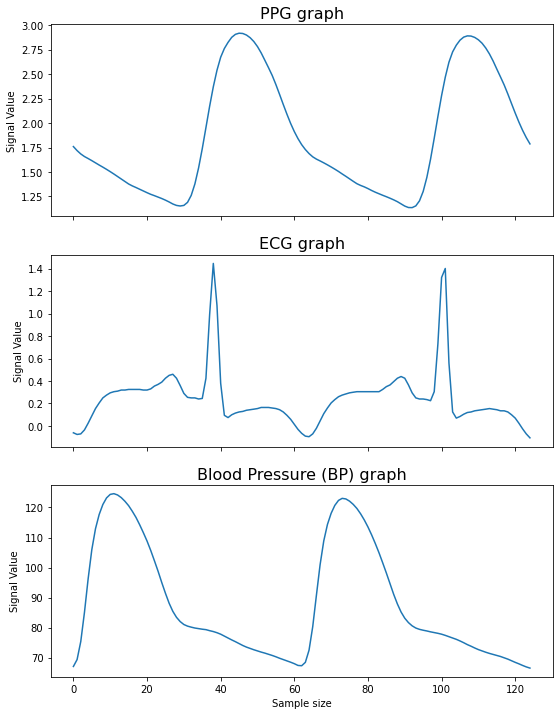

In [31]:
##plotting sample ppg, ecg and bp signals
##using a sample size of 125
fig, ax = plt.subplots(3,1, figsize=(9,12), sharex=True)

ax[0].set_title('PPG graph', fontsize=16)
ax[0].set_ylabel('Signal Value')
ax[0].plot(ppg[:125])

ax[1].set_title('ECG graph', fontsize=16)
ax[1].set_ylabel('Signal Value')
ax[1].plot(ecg[:125])

ax[2].set_title('Blood Pressure (BP) graph', fontsize=16)
ax[2].set_ylabel('Signal Value')
ax[2].set_xlabel('Sample size')
ax[2].plot(bp[:125])

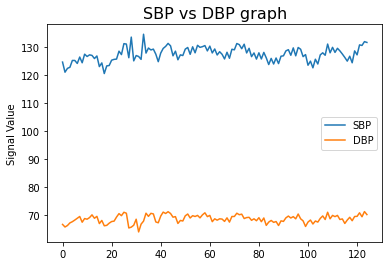

In [32]:
## Visualizing SBP and DBP
#fig, ax = plt.subplots(1,1, figsize=(9,12))

plt.title('SBP vs DBP graph', fontsize=16)
plt.ylabel('Signal Value')
plt.plot(sbp[:125])
plt.plot(dbp[:125])
plt.legend(['SBP', 'DBP'])

### Statistical Correlation of signals


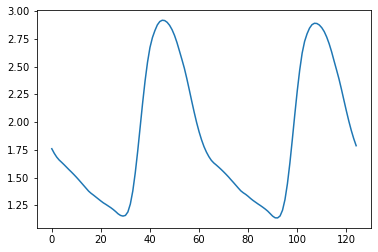

In [33]:
plt.plot(ppg[:125].squeeze())

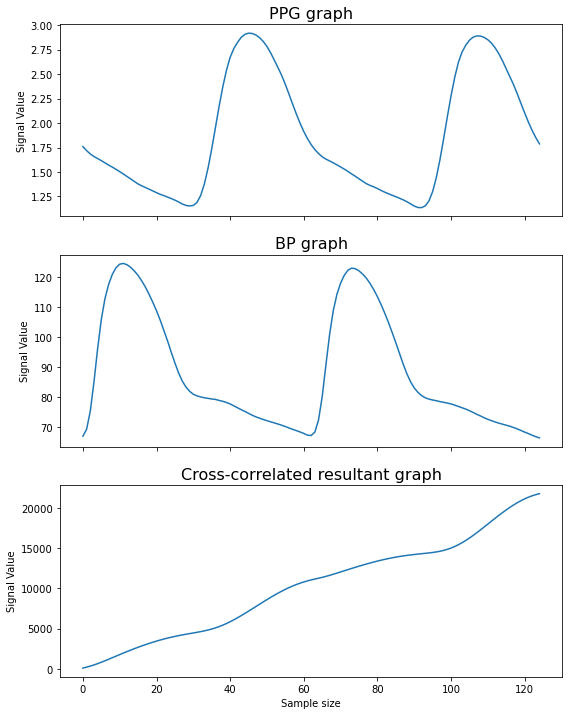

In [34]:
# Computing the cross correlation of ppg and bp signals
cross_corr = np.convolve(ppg[:125].squeeze(), bp[:125].squeeze(), mode='full')

fig, ax = plt.subplots(3,1, figsize=(9,12), sharex=True)

ax[0].set_title('PPG graph', fontsize=16)
ax[0].set_ylabel('Signal Value')
ax[0].plot(ppg[:125])

ax[1].set_title('BP graph', fontsize=16)
ax[1].set_ylabel('Signal Value')
ax[1].plot(bp[:125])

ax[2].set_title('Cross-correlated resultant graph', fontsize=16)
ax[2].set_ylabel('Signal Value')
ax[2].set_xlabel('Sample size')
ax[2].plot(cross_corr[:125])

### Are PPG signals Discrete Cosine Transform (DCT) of BP signals

Lets assume that `BP` is `dct(PPG)` or that `BP` is a discrete cosine transform of PPG and try to prove this hypothesis using the root mean squared error as our evaluation function.

In [35]:
#Computing the discrete cosine transform (DCT)
cosine_transformed_array = dct(ppg)
error = rmse(bp.squeeze(), cosine_transformed_array.squeeze())
print(f'RMSE: {error}')

RMSE: 92.6029607182544


In [36]:
# creating train and test sets
X_train, X_test, y_train, y_test = train_test_split(ppg, bp, test_size=0.30)

In [37]:
#Kfold cross-validation
folds = KFold(n_splits=5, shuffle=False)
scores = []
for i, (train_index, val_index) in enumerate(folds.split(X_train, y_train)):
    train_data, target = X_train[train_index], y_train[train_index]
    validation_data, val_target = X_train[val_index], y_train[val_index]
    
    model = LinearRegression()
    model.fit(train_data, target)
    #model = RandomForestRegressor(n_estimators=50,max_depth=5, n_jobs=-1, random_state=42)
    #model.fit(train_data[:100000], target[:100000].squeeze())  # training on few samples to save time.
    val_predictions = model.predict(validation_data)
    error = rmse(val_target, val_predictions)
    scores.append(error)
    print(f'Fold {i} RMSE: {error}')
print(f'Average RMSE over 5 folds: {np.mean(scores)}')

Fold 0 RMSE: 27.341577107598493
Fold 1 RMSE: 27.34115492174927
Fold 2 RMSE: 27.345515881122797
Fold 3 RMSE: 27.34608816611662
Fold 4 RMSE: 27.345698361827743
Average RMSE over 5 folds: 27.344006887682987


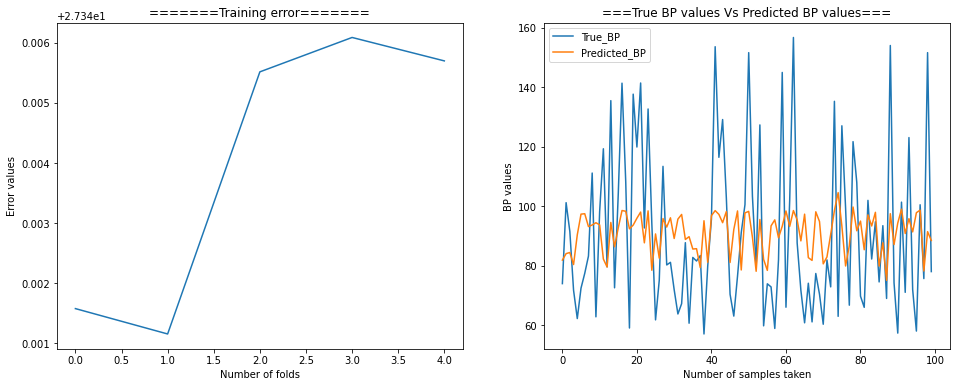

In [38]:
# Visualizing train error.
fig, ax = plt.subplots(1,2, figsize=(16,6))
ax[0].set_title("=======Training error=======")
ax[0].set_xlabel('Number of folds')
ax[0].set_ylabel('Error values')
ax[0].plot(scores)

# Visualize predicted BP and the True BP
ax[1].set_title("===True BP values Vs Predicted BP values===")
ax[1].set_xlabel('Number of samples taken')
ax[1].set_ylabel('BP values')
ax[1].plot(val_target[:100]) #only plotting 100 samples
ax[1].plot(val_predictions[:100])
ax[1].legend(['True_BP', 'Predicted_BP'])

In [39]:
# Predicting on the test set
test_predictions = model.predict(X_test[:1000000]) #predicting on the first 1million rows for speed.
test_error = rmse(y_test[:1000000], test_predictions)
print(f'Error on test set predictions: {test_error}')

Error on test set predictions: 27.371090162989244


## Predicting Blood Pressure using Deep Learning

For more resource about deep learning,[VISIT this site](https://www.tensorflow.org/tutorials/keras/regression)

In [40]:
import tensorflow as tf
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.layers import Activation
from tensorflow.keras.layers import Dropout
from tensorflow.keras.models import Sequential
from tensorflow.keras import optimizers

In [41]:
def Model(input_dim, activation, num_class):
    model = Sequential()

    model.add(Dense(1024, input_dim = input_dim))
    model.add(Activation(activation))
    model.add(Dropout(0.5))



    model.add(Dense(num_class))    
    model.add(Activation('linear'))
    
    model.compile(loss='Huber',
                  optimizer=optimizers.Adam(lr = 0.001),
                  metrics=['MeanAbsoluteError']
                 )
    return model

In [42]:
input_dim = X_train.shape[1]
activation = 'relu'
classes = 1
model = Model(input_dim=input_dim, activation=activation, num_class=classes)
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_3 (Dense)              (None, 1024)              2048      
_________________________________________________________________
activation_3 (Activation)    (None, 1024)              0         
_________________________________________________________________
dropout_2 (Dropout)          (None, 1024)              0         
_________________________________________________________________
dense_4 (Dense)              (None, 1)                 1025      
_________________________________________________________________
activation_4 (Activation)    (None, 1)                 0         
Total params: 3,073
Trainable params: 3,073
Non-trainable params: 0
_________________________________________________________________


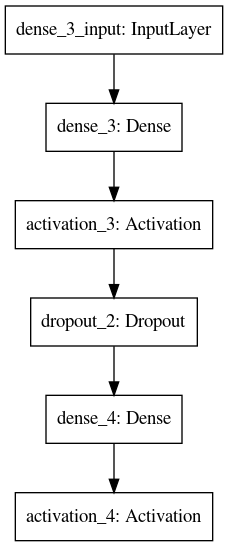

In [43]:
# Visualizing the model
tf.keras.utils.plot_model(model)

In [44]:
# Training the model
history = model.fit(X_train[:1000000], # using the first 1million rows for speed.
                    y_train[:1000000].squeeze(),
                    epochs=20,
                    batch_size=128,
                    verbose = 1
                   )

Epoch 1/20
7813/7813 [==============================] - 16s 2ms/step - loss: 23.0113 - mean_absolute_error: 23.5064
Epoch 2/20
7813/7813 [==============================] - 17s 2ms/step - loss: 21.2210 - mean_absolute_error: 21.7158
Epoch 3/20
7813/7813 [==============================] - 16s 2ms/step - loss: 21.1934 - mean_absolute_error: 21.6881
Epoch 4/20
7813/7813 [==============================] - 17s 2ms/step - loss: 21.1994 - mean_absolute_error: 21.6942
Epoch 5/20
7813/7813 [==============================] - 16s 2ms/step - loss: 21.1930 - mean_absolute_error: 21.6878
Epoch 6/20
7813/7813 [==============================] - 17s 2ms/step - loss: 21.1822 - mean_absolute_error: 21.6770
Epoch 7/20
7813/7813 [==============================] - 16s 2ms/step - loss: 21.1677 - mean_absolute_error: 21.6625
Epoch 8/20
7813/7813 [==============================] - 16s 2ms/step - loss: 21.1786 - mean_absolute_error: 21.6733
Epoch 9/20
7813/7813 [==============================] - 16s 2ms/step - l

In [45]:
#Predicting on the test set using the nn(neural network) model
nn_predictions = model.predict(X_test[:1000000])
error = rmse(y_test[:1000000], nn_predictions)
print(f'Neural Net RMSE: {error}')

Neural Net RMSE: 27.701639309135825


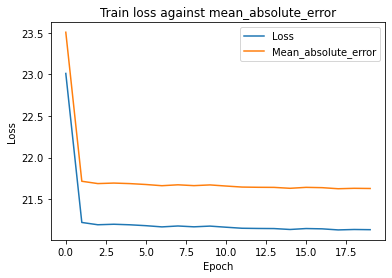

In [46]:
plt.title('Train loss against mean_absolute_error')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.plot(history.history['loss'])
plt.plot(history.history['mean_absolute_error'])
plt.legend(['Loss', 'Mean_absolute_error'])

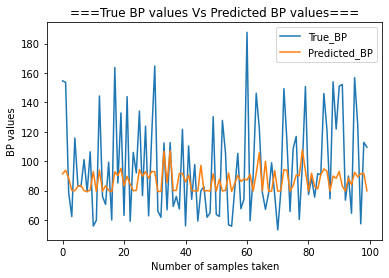

In [47]:
# Visualize predicted BP and the True BP
plt.title("===True BP values Vs Predicted BP values===")
plt.xlabel('Number of samples taken')
plt.ylabel('BP values')
plt.plot(y_test[:100]) #only plotting 100 samples
plt.plot(nn_predictions[:100])
plt.legend(['True_BP', 'Predicted_BP'])